# Project description

In this project, we aim to characterise the effect of Foxa2 in the determination of endoderm and mesoderm lineages in the mouse embryo.

**In this notebook:** 
Characterisation of the mesoderm and endoderm lineage using diffusion pseudotime.

# Initialisation

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann
import gseapy as gp
import scvelo as scv

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors
from seaborn import heatmap
from matplotlib import gridspec

import os

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.5.2.dev6+gfa408dc7 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
import matplotlib
matplotlib.__version__

'3.1.3'

In [3]:
import datetime

today = datetime.date.today().strftime('%y%m%d')

In [4]:
#%matplotlib inline
#%config InlineBackend.figure_format='retina' # mac

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
data_dir = './../data/'

In [5]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)


In [6]:
sb.set_style('white')

Add my color scheme.

In [7]:
colors2 = pl.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = pl.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [8]:
colors_red = pl.cm.Reds_r(np.linspace(0, 0.8, 128))
myreds = colors.LinearSegmentedColormap.from_list('my_colormap', colors_red)

# Load dataset

Load batch corrected and annotated dataset with logCPM-normalized, but non-batch corrected values as `raw`.

In [9]:
adata = sc.read(data_dir + 'data_annotated_dec20.h5ad')

In [10]:
adata

AnnData object with n_obs × n_vars = 9794 × 3000 
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'tissues_final', 'Foxa2_levels', 'tissue_Foxa2', 'FVF_Foxa2'
    uns: 'ADE_vs_TP', 'FVF_Foxa2_colors', 'FVF_colors', 'Foxa2_pEpi_vs_TP', 'Foxa2pos_vs_Foxa2neg_pEpi', 'batch_colors', 'dendrogram_endoderm_res', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_final', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_colors', 'louvain', 'louvain_R_colors', 'louvain_colors', 'neighbors', 'pEpi_vs_TP', 'pca', 'rank_genes_groups', 'tissue_Foxa2_colors', 'tissues_colors', 'tissues_final_colors', 'tissues_merge_colors', 'tissues_primed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

# Pseudotime analysis for endoderm and mesoderm lineage

Here, we select the subset of endoderm related cells and (posterior) epiblast.

In [11]:
subset_idx = np.in1d(adata.obs['tissues_final'], ['epiblast',
                                                   'posterior epiblast',
                                                   'transitory progenitors',
                                                   'anterior definitive endoderm']) 

In [12]:
adata_endo = adata[subset_idx,:].copy()

In [13]:
adata_endo

AnnData object with n_obs × n_vars = 5195 × 3000 
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'tissues_final', 'Foxa2_levels', 'tissue_Foxa2', 'FVF_Foxa2'
    uns: 'ADE_vs_TP', 'FVF_Foxa2_colors', 'FVF_colors', 'Foxa2_pEpi_vs_TP', 'Foxa2pos_vs_Foxa2neg_pEpi', 'batch_colors', 'dendrogram_endoderm_res', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_final', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_colors', 'louvain', 'louvain_R_colors', 'louvain_colors', 'neighbors', 'pEpi_vs_TP', 'pca', 'rank_genes_groups', 'tissue_Foxa2_colors', 'tissues_colors', 'tissues_final_colors', 'tissues_merge_colors', 'tissues_primed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Recompute embeddings.

In [14]:
sc.tl.pca(adata_endo, svd_solver='arpack')
sc.pp.neighbors(adata_endo)
sc.tl.umap(adata_endo)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [15]:
sc.tl.diffmap(adata_endo)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9953599  0.97498006 0.96271473 0.95992106 0.9513408
     0.9374736  0.9209783  0.9166976  0.9124596  0.90534306 0.9005565
     0.89500344 0.890638   0.8817539 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


Second, we select the cells for the mesoderm lineage.

In [37]:
subset_meso_idx = np.in1d(adata.obs['tissues_final'], [ 'epiblast',
                                                   'posterior epiblast',
                                                'nascent endothelium',
                                                      'lateral plate mesoderm',
       'paraxial mesoderm', 'intermediate mesoderm', 'mesoderm progenitors']) 

In [38]:
adata_meso = adata[subset_meso_idx,:].copy()

In [39]:
adata_meso

AnnData object with n_obs × n_vars = 8005 × 3000 
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'tissues_final', 'Foxa2_levels', 'tissue_Foxa2', 'FVF_Foxa2'
    uns: 'ADE_vs_TP', 'FVF_Foxa2_colors', 'FVF_colors', 'Foxa2_pEpi_vs_TP', 'Foxa2pos_vs_Foxa2neg_pEpi', 'batch_colors', 'dendrogram_endoderm_res', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_final', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_colors', 'louvain', 'louvain_R_colors', 'louvain_colors', 'neighbors', 'pEpi_vs_TP', 'pca', 'rank_genes_groups', 'tissue_Foxa2_colors', 'tissues_colors', 'tissues_final_colors', 'tissues_merge_colors', 'tissues_primed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

Recompute embeddings.

In [40]:
sc.tl.pca(adata_meso, svd_solver='arpack')
sc.pp.neighbors(adata_meso)
sc.tl.umap(adata_meso)

computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [41]:
sc.tl.diffmap(adata_meso)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9958123  0.9824334  0.9734334  0.9627739  0.9619189
     0.95597464 0.94720316 0.93513644 0.9307156  0.9293385  0.9253425
     0.91581845 0.9138713  0.9118923 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


# Line plots 

In this section, we compute a pseudotime from epiblast to endoderm and epiblast to mesoderm, respectively. Then, we display the gene scores and genes of interest along the pseudotime axis as a line plot (code adapted from Sophie Tritschler's publication on [pancreatic endocrinogenesis](https://github.com/theislab/pancreatic-endocrinogenesis/blob/master/scRNA_seq_main_analysis.ipynb).  


## Compute DPT

### Towards endoderm

In [16]:
DC1 = [first[0] for first in adata_endo.obsm['X_diffmap']]
DC2 = [first[1] for first in adata_endo.obsm['X_diffmap']]

In [17]:
DC_tmp = [first[0] +first[1] for first in adata_endo.obsm['X_diffmap']]

In [18]:
adata_endo.uns['iroot'] =np.argsort(DC_tmp)[-1]
print(adata_endo.uns['iroot'])
sc.tl.dpt(adata_endo, n_branchings=2, n_dcs=5, allow_kendall_tau_shift=True)

3189
computing Diffusion Pseudotime using n_dcs=5
    this uses a hierarchical implementation
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:01)


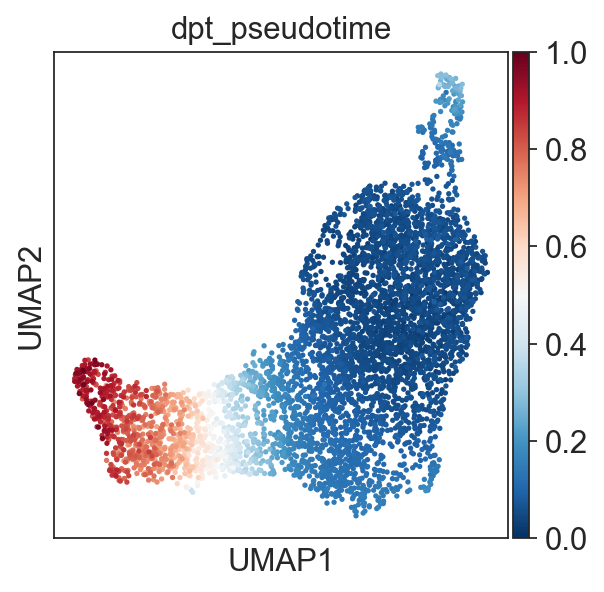

In [19]:
sc.pl.umap(adata_endo[adata_endo.obs['dpt_pseudotime']<1.1], color='dpt_pseudotime', color_map='RdBu_r')

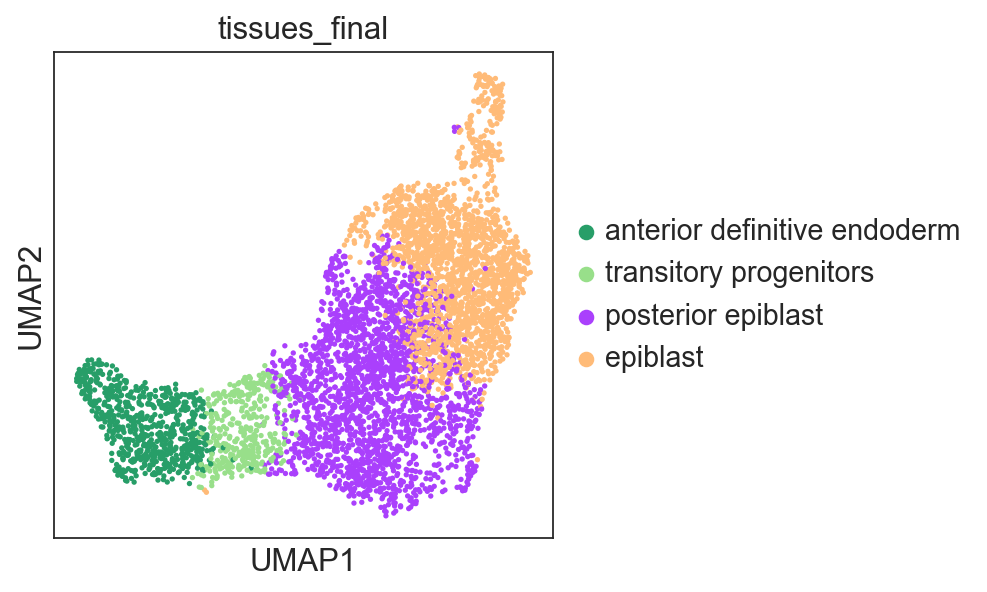

In [20]:
sc.pl.umap(adata_endo, color='tissues_final')

In [21]:
del adata_endo.raw.varm['PCs']

### Towards Mesoderm

In [42]:
DC1 = [first[0] for first in adata_meso.obsm['X_diffmap']]
DC2 = [first[1] for first in adata_meso.obsm['X_diffmap']]

In [43]:
adata_meso.uns['iroot'] =np.argsort(DC2)[0]
print(adata_meso.uns['iroot'])
sc.tl.dpt(adata_meso, n_branchings=1, n_dcs=5, allow_kendall_tau_shift=True)

3147
computing Diffusion Pseudotime using n_dcs=5
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs) (0:00:02)


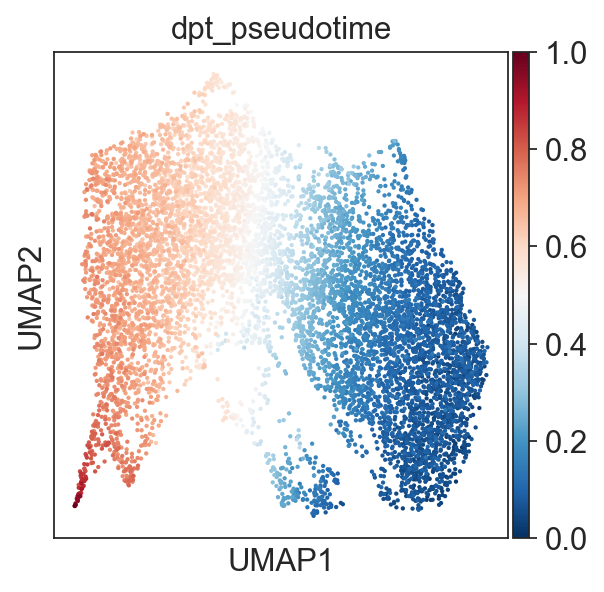

In [44]:
sc.pl.umap(adata_meso[adata_meso.obs['dpt_pseudotime']<1.1], color='dpt_pseudotime', color_map='RdBu_r')

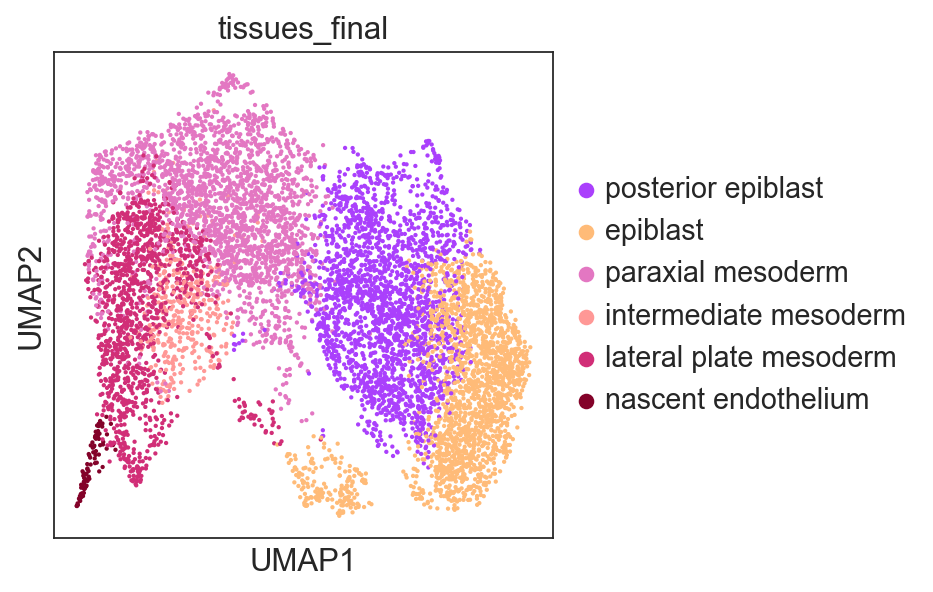

In [45]:
sc.pl.umap(adata_meso, color='tissues_final', color_map='RdBu_r')

In [46]:
del adata_meso.raw.varm['PCs']

## Create line plots

Define colors for plotting.

In [22]:
add_colors = [keys for keys in matplotlib.colors.CSS4_COLORS.keys()]

In [23]:

cols=['red','blue','green','cyan','yellow','grey','orange','darkred','lightgreen','darkviolet','peru','sienna','magenta','darkseagreen','palevioletred',
     'cornflowerblue','lightsalmon']
cols.extend(add_colors)

### Endoderm

In [24]:
col_clust = adata_endo.uns['tissues_final_colors']

Interpolate the gene expression of selected Wnt and delamination genes towards endoderm and mesoderm as quadratic spline function.

In [25]:
genes_lineplot_wnt = ['Wnt3', 'Lef1', 'Cer1', 'Dkk1', 'Sfrp1', 'Sfrp5']
genes_delam = ['Ezr', 'Crb3', 'Slc9a3r1', 'Cldn7', 'Pard6b']

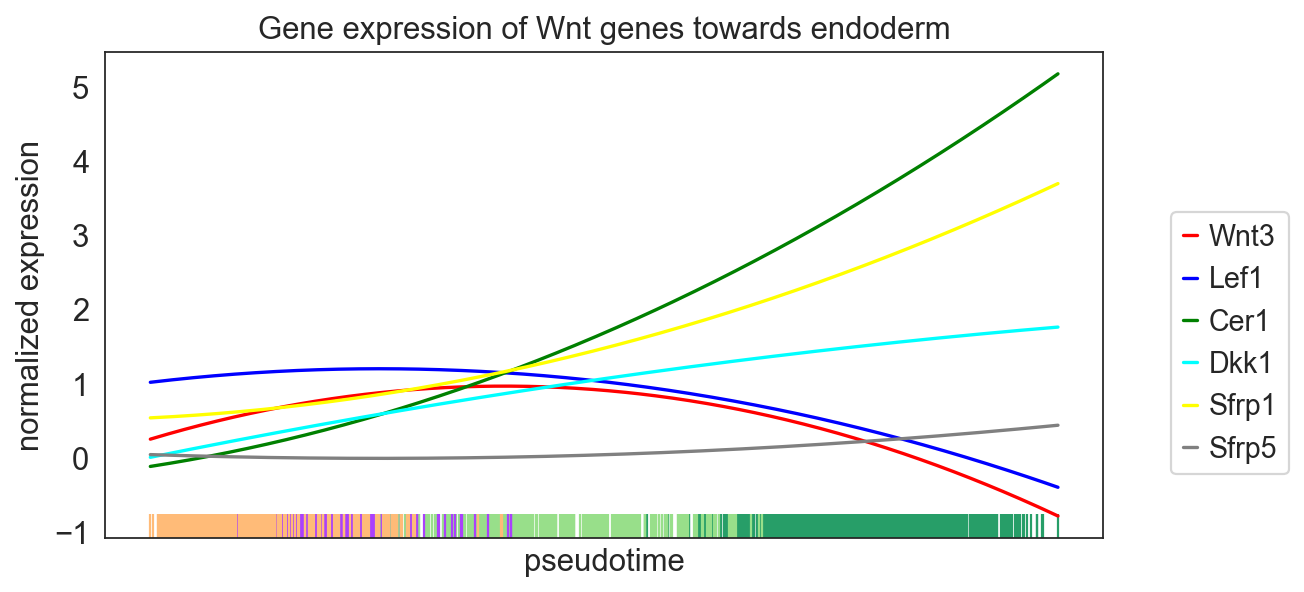

In [26]:
#genes=['Fev','Tox3','BC023829','Pax4','Cck','Neurod1','Vwa5b2','Celf3','Runx1t1','Cacna2d1']
adata_tmp = adata_endo.raw[:,genes_lineplot_wnt].copy()

df=pd.DataFrame(adata_tmp.X.toarray(),columns=genes_lineplot_wnt)
df['pseudotime']=adata_endo.obs['dpt_pseudotime'].values
df['clusters']=adata_endo.obs['tissues_final'].values

df=df.sort_values(by='pseudotime',ascending=False)

rcParams['figure.figsize'] = (8, 4)

fig,ax=pl.subplots()


for i,gene in enumerate(genes_lineplot_wnt):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=2)
    f = np.poly1d(fit)
    
    sb.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
    
    
for i,clust in enumerate(adata_endo.obs['tissues_final'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sb.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=col_clust[i])

pl.ylabel('normalized expression')
ax.set_xticks([])
ax.set_xticklabels([])
ax.legend(bbox_to_anchor=(1.2, 0.7))
pl.title('Gene expression of Wnt genes towards endoderm')
pl.savefig('./figures/' + today + '_wnt_signature_endoderm_lineplot.pdf',format='pdf',dpi=300, bbox_inches='tight')

pl.show()

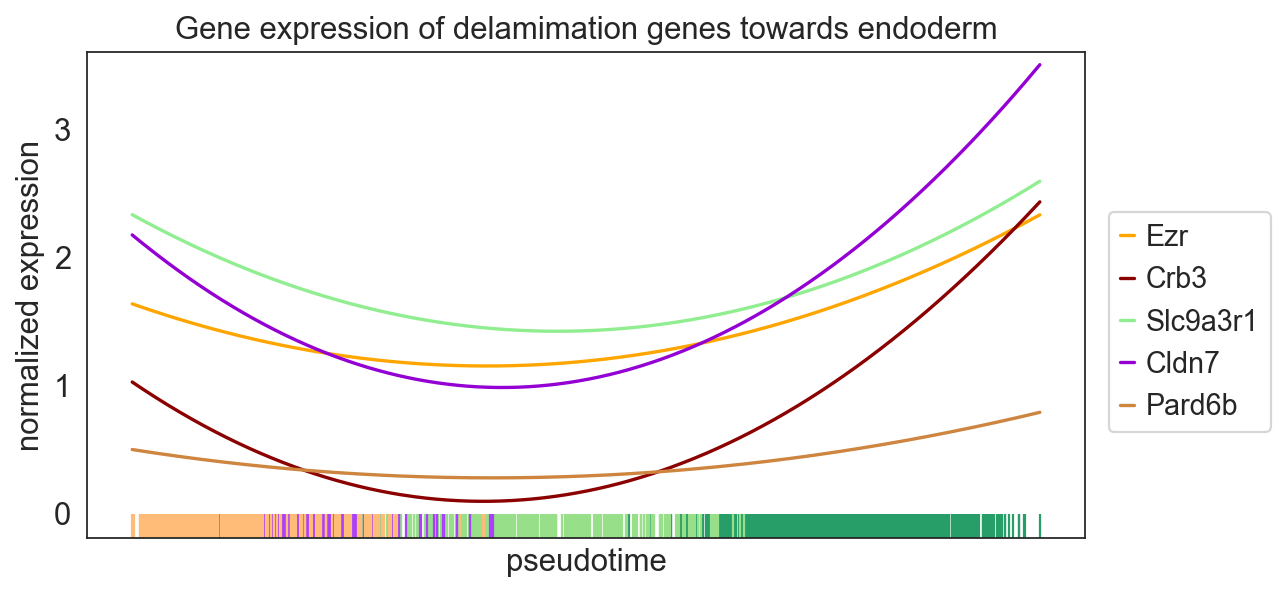

In [31]:
#genes=['Fev','Tox3','BC023829','Pax4','Cck','Neurod1','Vwa5b2','Celf3','Runx1t1','Cacna2d1']
adata_tmp = adata_endo.raw[:,genes_delam].copy()

df=pd.DataFrame(adata_tmp.X.toarray(),columns=genes_delam)
df['pseudotime']=adata_endo.obs['dpt_pseudotime'].values
df['clusters']=adata_endo.obs['tissues_final'].values

df=df.sort_values(by='pseudotime',ascending=True)

rcParams['figure.figsize'] = (8, 4)

fig,ax=pl.subplots()


for i,gene in enumerate(genes_delam):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=2)
    f = np.poly1d(fit)
    
    sb.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i+6],ax=ax,label=gene)
    
    
for i,clust in enumerate(adata_endo.obs['tissues_final'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sb.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=col_clust[i])

pl.ylabel('normalized expression')
ax.set_xticks([])
ax.set_ylim([-0.2,3.6])
ax.set_xticklabels([])
ax.legend(bbox_to_anchor=(1.2, 0.7))
pl.title('Gene expression of delamimation genes towards endoderm')
pl.savefig('./figures/' + today + '_delamination_signature_endoderm_lineplot.pdf',
           format='pdf',dpi=300, bbox_inches='tight')

pl.show()

### Mesoderm

In [53]:
col_clust = adata_meso.uns['tissues_final_colors']

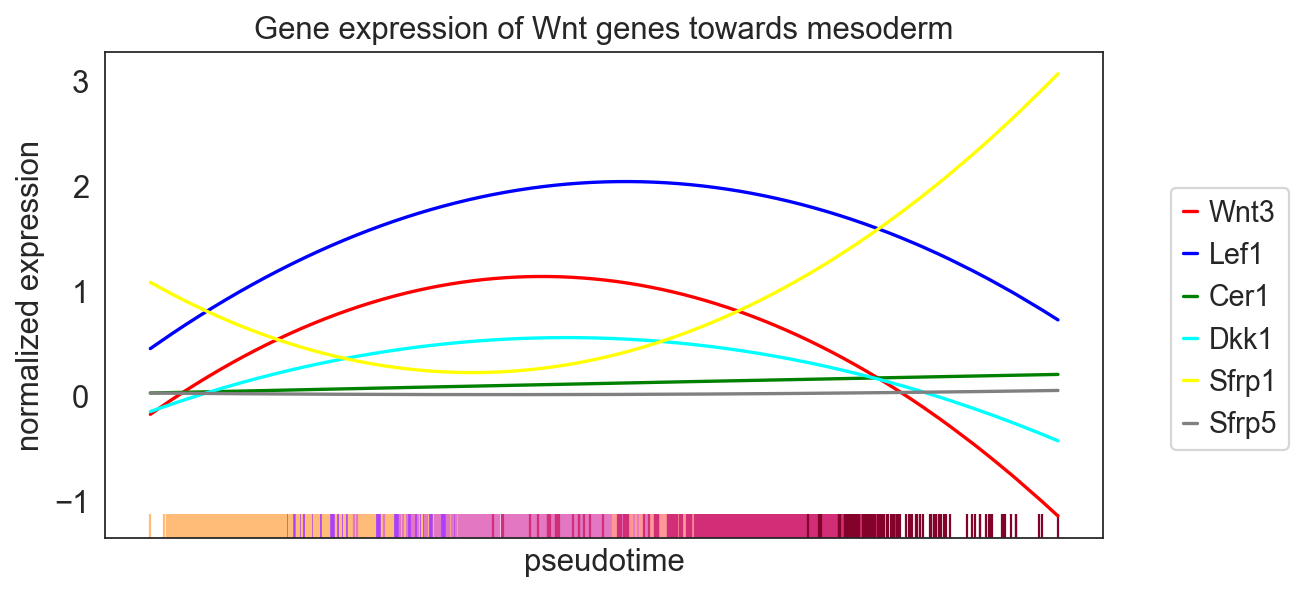

In [54]:
#genes=['Fev','Tox3','BC023829','Pax4','Cck','Neurod1','Vwa5b2','Celf3','Runx1t1','Cacna2d1']
adata_tmp = adata_meso.raw[:,genes_lineplot_wnt].copy()

df=pd.DataFrame(adata_tmp.X.toarray(),columns=genes_lineplot_wnt)
df['pseudotime']=adata_meso.obs['dpt_pseudotime'].values
df['clusters']=adata_meso.obs['tissues_final'].values

df=df.sort_values(by='pseudotime',ascending=True)

rcParams['figure.figsize'] = (8, 4)

fig,ax=pl.subplots()


for i,gene in enumerate(genes_lineplot_wnt):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=2)
    f = np.poly1d(fit)
    
    sb.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i],ax=ax,label=gene)
    
    
for i,clust in enumerate(adata_meso.obs['tissues_final'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sb.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=col_clust[i])

pl.ylabel('normalized expression')
ax.set_xticks([])
ax.set_xticklabels([])
ax.legend(bbox_to_anchor=(1.2, 0.75))
pl.title('Gene expression of Wnt genes towards mesoderm')
pl.savefig('./figures/' + today + '_wnt_signature_mesoderm_lineplot.pdf',format='pdf',dpi=300, bbox_inches='tight')

pl.show()

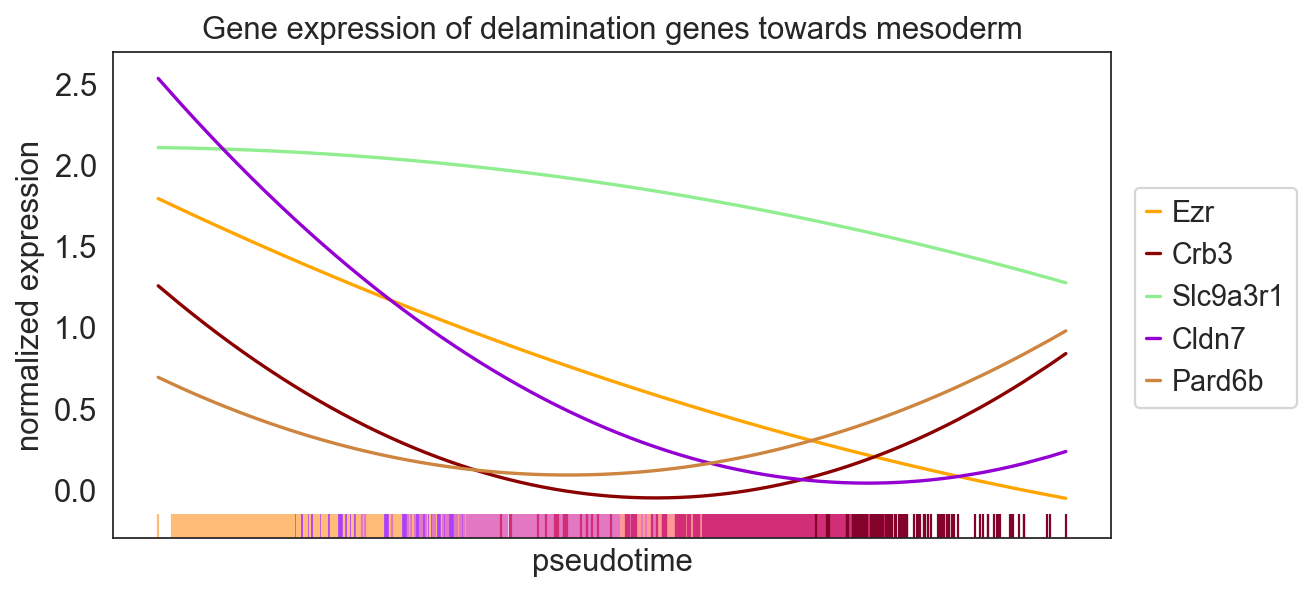

In [56]:
#genes=['Fev','Tox3','BC023829','Pax4','Cck','Neurod1','Vwa5b2','Celf3','Runx1t1','Cacna2d1']
adata_tmp = adata_meso.raw[:,genes_delam].copy()

df=pd.DataFrame(adata_tmp.X.toarray(),columns=genes_delam)
df['pseudotime']=adata_meso.obs['dpt_pseudotime'].values
df['clusters']=adata_meso.obs['tissues_final'].values

df=df.sort_values(by='pseudotime',ascending=True)

rcParams['figure.figsize'] = (8, 4)

fig,ax=pl.subplots()


for i,gene in enumerate(genes_delam):
    fit=np.polyfit(df['pseudotime'].values,df[gene].values,deg=2)
    f = np.poly1d(fit)
    
    sb.lineplot(y=f(df['pseudotime']), x=df['pseudotime'].values,color=cols[i+6],ax=ax,label=gene)
    
    
for i,clust in enumerate(adata_meso.obs['tissues_final'].cat.categories):
    df_sub=df[np.isin(df['clusters'],clust)]
    sb.distplot(df_sub['pseudotime'],kde=False, hist=False, rug=True, ax=ax,color=col_clust[i])

pl.ylabel('normalized expression')
ax.set_ylim([-0.3,2.7])
ax.set_xticks([])
ax.set_xticklabels([])
ax.legend(bbox_to_anchor=(1.2, 0.75))
pl.title('Gene expression of delamination genes towards mesoderm')
pl.savefig('./figures/' + today + '_delam_signature_mesoderm_lineplot.pdf',format='pdf',dpi=300, bbox_inches='tight')

pl.show()